# Exploration Notebook

## Import Libraries

In [145]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
print(torch.__version__)

2.0.1


## Useful Functions

In [3]:
def read_data(data_path):
    with open(data_path, 'r') as file:
        data = file.read()
        
    return data

## Load Data

In [5]:
text = read_data('../data/input.txt')

In [9]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Tokenization

In [19]:
all_chars = sorted(list(set(text)))
vocab_size = len(all_chars)

print(f"We have {vocab_size} vocabulary in our dataset")
print(f"All characters: { ''.join(all_chars) }")

We have 65 vocabulary in our dataset
All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


We must now tokenize the text at character level, in order to do that, we must create:
- **Encoder**: which converts the character to numerical representation.
- **Decoder**: which converts the numerical representation to character again.

In [20]:
# Create two ways mapping
c2i = { char:idx for idx, char in enumerate(all_chars) }
i2c = { idx:char for idx, char in enumerate(all_chars) }

encoder = lambda string: [ c2i[char] for char in string ]
decoder = lambda indexes: "".join([ i2c[idx] for idx in indexes ])

In [21]:
test_phrase = "Hello my name is Khalil!"
print(test_phrase)
print(encoder(test_phrase))
print(decoder(encoder(test_phrase)))

Hello my name is Khalil!
[20, 43, 50, 50, 53, 1, 51, 63, 1, 52, 39, 51, 43, 1, 47, 57, 1, 23, 46, 39, 50, 47, 50, 2]
Hello my name is Khalil!


Now we will tokenize the whole training set. We will start using **torch** library.

In [22]:
data = torch.tensor(encoder(text), dtype=torch.long)

In [23]:
print(f"We've got: {data.shape} shape and {data.dtype} Tensor's type.")

We've got: torch.Size([1115394]) shape and torch.int64 Tensor's type.


## Split Data to Train, Eval and Test sets

In [25]:
len(data)

1115394

In [26]:
def split_data(data, train_percent, eval_percent, test_percent):
    
    assert train_percent + eval_percent + test_percent == 1.0, f"The summation of all percentags must be 1.0, we got {train_percent + eval_percent + test_percent}"
    
    train_range = [0, int( len(data) * train_percent )]
    eval_range = [ train_range[1], int( len(data) * eval_percentage ) + train_range[1] ]
    test_range = [eval_range[1], -1]
    
    return data[:train_range[1]], data[eval_range[0]:eval_range[1]], data[test_range[0]:]

In [27]:
train_percentage = 0.8
eval_percentage = 0.1
test_percentage = 0.1

train_set, eval_set, test_set = split_data(data, train_percentage, eval_percentage, test_percentage)

## Split the data into Chunks

We don't train the GPT-decoder all at once as it will take a lot of time to do that, instead, we split the data into chunks of **context_length** plus one.

You might ask youtself why plus one? The reason why is when at each chunk, we try to predict the i+1. For instance, if the **context_length** is equal to 8:

- at i=0, GPT predicts i+1=1
- at i=1, GPT preducts i+1=2
.
.
.

To reach i=**context_length**, GPT predicts i+1=**context_length** + 1

One more thing to mention is we do that as well to make the neural network to learn how to predict the next token from index equals **zero** to index equals **context_length**.

In [31]:
CONTEXT_LENGTH = 8

x = train_set[:CONTEXT_LENGTH]
y = train_set[1:CONTEXT_LENGTH+1]

for idx in range(CONTEXT_LENGTH):
    context = x[:idx+1].tolist()
    target = y[idx]
    print(f"When the input is {context}, GPT will try to predict {target}")

When the input is [18], GPT will try to predict 47
When the input is [18, 47], GPT will try to predict 56
When the input is [18, 47, 56], GPT will try to predict 57
When the input is [18, 47, 56, 57], GPT will try to predict 58
When the input is [18, 47, 56, 57, 58], GPT will try to predict 1
When the input is [18, 47, 56, 57, 58, 1], GPT will try to predict 15
When the input is [18, 47, 56, 57, 58, 1, 15], GPT will try to predict 47
When the input is [18, 47, 56, 57, 58, 1, 15, 47], GPT will try to predict 58


Moreover, we will add the batch size. We use batches to stack list of chunks on top of each other in order to keep the GPUS busy all the time. They run independently.

In [32]:
BATCH_SIZE = 4
def get_batch(data, batch_size=BATCH_SIZE, context_length=CONTEXT_LENGTH):
    """
    Function to generate small batch of data
    """
    # get BATCH_SIZE random indexes within the dataset
    # This will return torch.Tensor with 4 values, shape: [4]
    indexes = torch.randint( len(data) - batch_size, (batch_size,) )  
    # loop through each index and get the context data and finally stack them together to get torch.tensor of shape (BATCH_SIZE, CONTEXT_LENGTH) 
    x = torch.stack( [ data[ idx: idx+context_length ] for idx in indexes ] )
    # loop through each index and get the target data and finally stack them together to get torch.tensor of shape (BATCH_SIZE, CONTEXT_LENGTH)
    y = torch.stack( [ data[idx+1:idx+context_length+1] for idx in indexes ] )
    
    return x, y

In [59]:
torch.manual_seed(100)

x, y = get_batch(train_set)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  torch.Size([4, 8])
y shape:  torch.Size([4, 8])


In [60]:
x

tensor([[61, 46, 47, 54,  1, 63, 53, 59],
        [63,  1, 57, 43, 58,  1, 42, 53],
        [58, 46, 47, 52, 49,  1, 63, 53],
        [63,  1, 61, 47, 52, 45,  6,  0]])

In [61]:
y

tensor([[46, 47, 54,  1, 63, 53, 59,  1],
        [ 1, 57, 43, 58,  1, 42, 53, 61],
        [46, 47, 52, 49,  1, 63, 53, 59],
        [ 1, 61, 47, 52, 45,  6,  0, 22]])

In [67]:
examples_nb = 0
for b in range(BATCH_SIZE):
    for c in range(CONTEXT_LENGTH):
        context = x[b, :c+1].tolist()
        target = y[b, c]
        print(f"Input: {context}, Output: {target}")
        examples_nb += 1
    print()
    
print(f"We have {examples_nb} to train on. This comes from BATCH_SIZE x CONTEXT_LENGTH = {BATCH_SIZE} x {CONTEXT_LENGTH}")

Input: [61], Output: 46
Input: [61, 46], Output: 47
Input: [61, 46, 47], Output: 54
Input: [61, 46, 47, 54], Output: 1
Input: [61, 46, 47, 54, 1], Output: 63
Input: [61, 46, 47, 54, 1, 63], Output: 53
Input: [61, 46, 47, 54, 1, 63, 53], Output: 59
Input: [61, 46, 47, 54, 1, 63, 53, 59], Output: 1

Input: [63], Output: 1
Input: [63, 1], Output: 57
Input: [63, 1, 57], Output: 43
Input: [63, 1, 57, 43], Output: 58
Input: [63, 1, 57, 43, 58], Output: 1
Input: [63, 1, 57, 43, 58, 1], Output: 42
Input: [63, 1, 57, 43, 58, 1, 42], Output: 53
Input: [63, 1, 57, 43, 58, 1, 42, 53], Output: 61

Input: [58], Output: 46
Input: [58, 46], Output: 47
Input: [58, 46, 47], Output: 52
Input: [58, 46, 47, 52], Output: 49
Input: [58, 46, 47, 52, 49], Output: 1
Input: [58, 46, 47, 52, 49, 1], Output: 63
Input: [58, 46, 47, 52, 49, 1, 63], Output: 53
Input: [58, 46, 47, 52, 49, 1, 63, 53], Output: 59

Input: [63], Output: 1
Input: [63, 1], Output: 61
Input: [63, 1, 61], Output: 47
Input: [63, 1, 61, 47], Ou

## Build Bigram Language Model

Now let's build the **Bigram Language Model** to feed the batches to it.

For the lose function, we will use the **Negative log likelihood** function to calculate the loss between logits and target. To do that we can use **F.cross_entropy** from **torch**.

**cross_entropy** expects the **vocab_size** to be the second dims, thus we will reshape the inputs and outputs.

In [211]:
torch.manual_seed(100)

class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, context, targets=None):
        
        # this returns a torch.tensor with shape of (BATCH_SIZE, CONTEXT_LENGTH, VOCAB_SIZE)
        # e.g. (4, 8, 65)
        logits = self.embedding_table(context)
        
        if targets == None:
            loss = None
        
        else:
            B, C, V = logits.shape # e.g. (4, 8, 65)

            # we're going to strech out the array, new shape: (BATCH_SIZE * CONTEXT_LENGTH, VOCAB_SIZE)
            # e.g. (4*8, 65) == (32, 65)
            logits = logits.view(B*C, V)

            # and for the targets as well, we're going to change it's shape to be one dim
            # e.g. (4*8) = (32)
            targets = targets.view(B*C)
            
            # log likelihood is used to measure the quality of the prediction
            loss = F.cross_entropy(input=logits, target=targets)
        
        return logits, loss
    
    
    def generate(self, context, max_tokens, device="mps"):
        # Fist of all the context is with (B, C) shape
        for _ in range(max_tokens):
            # we get the prediction, the logits will be in (B, C, V) shape and the loss will be None
            logits, loss = self(context)
            # Focus only on the last character, this will change later
            logits = logits[:, -1, :]
            # get the probability distribuation where the sum of probabilities are equal to 1
            probs = F.softmax(logits, dim=1)
            # get random sample distribution from the probability
            # next_token = torch.multinomial(probs, num_samples=1)
            next_token = torch.multinomial(probs.to('cpu'), num_samples=1).to('mps')
            # concatinate the generated token with the previous set of tokens
            context = torch.cat((context, next_token), dim=1)
        
        return context

In [156]:
bigram_model = BigramLanguageModel(vocab_size)

logits, loss = bigram_model(x, y)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8401, grad_fn=<NllLossBackward0>)


In [111]:
# Test
test_idx = torch.zeros((1, 1), dtype=torch.long)
generated_results = bigram_model.generate(test_idx, max_tokens=100)[0].tolist()
print(generated_results)
decoder(generated_results)

[0, 44, 15, 9, 25, 9, 40, 15, 9, 39, 43, 8, 18, 51, 30, 14, 39, 48, 63, 48, 58, 61, 10, 33, 50, 61, 46, 12, 61, 45, 12, 15, 4, 8, 20, 43, 36, 44, 5, 14, 11, 17, 49, 20, 35, 27, 50, 22, 2, 6, 11, 50, 25, 19, 9, 23, 58, 2, 17, 49, 47, 30, 14, 11, 27, 3, 14, 31, 10, 34, 30, 50, 3, 35, 1, 55, 32, 57, 42, 58, 20, 35, 47, 27, 60, 46, 11, 8, 54, 17, 47, 41, 48, 19, 15, 42, 34, 2, 50, 31, 58]


"\nfC3M3bC3ae.FmRBajyjtw:Ulwh?wg?C&.HeXf'B;EkHWOlJ!,;lMG3Kt!EkiRB;O$BS:VRl$W qTsdtHWiOvh;.pEicjGCdV!lSt"

## Training the Bigram Language Model

In [237]:
def training_loop(model, train_data, eval_data, epochs, eval_interval, optimizer, batch_size, context_length, device):
    
    model.to(device)
    model.train()
    training_loss = []
    eval_loss = []
    
    for epoch in range(epochs):
        if epoch % eval_interval == 0:
            losses = validation(model, train_data, eval_data, 100, device)
            training_loss.append(losses['train'])
            eval_loss.append(losses['eval'])
            print(f"Epoch: {epoch}, Training Loss: {losses['train']}, Eval Loss: {losses['eval']}")
    
        x, y = get_batch(train_data, batch_size, context_length)
        x, y = x.to(device), y.to(device)

        logits, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return training_loss, eval_loss

@torch.no_grad()
def validation(model, train_data, eval_data, eval_epoch, device="mps"):
    output = {}
    model.eval()
    model.to(device)

    # train data
    losses = torch.zeros(eval_epoch)
    for k in range(eval_epoch):
        X, y = get_batch(train_data)
        X, y = X.to(device), y.to(device)
        logits, loss = model(X, y)
        losses[k] = loss.item()

    output['train'] = losses.mean()

    # eval data
    losses = torch.zeros(eval_epoch)
    for k in range(eval_epoch):
        X, y = get_batch(eval_data)
        X, y = X.to(device), y.to(device)
        logits, loss = model(X, y)
        losses[k] = loss.item()

    output['eval'] = losses.mean()

    model.train()
    return output

def plot_loss(train_loss_values, val_loss_values):
    """
    Plot the training and validation loss values over training epochs with a line plot.

    Parameters:
    - train_loss_values (list): List of training loss values at each epoch.
    - val_loss_values (list): List of validation loss values at each epoch.
    """
    epochs = range(1, len(train_loss_values) + 1)

    # Plotting the training loss values with a line plot
    plt.plot(epochs, train_loss_values, label='Training Loss', marker='o', linestyle='-')

    # Plotting the validation loss values with a line plot
    plt.plot(epochs, val_loss_values, label='Validation Loss', marker='o', linestyle='-')

    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()

In [238]:
# define an optimizer
device = 'mps'
bigram_model = BigramLanguageModel(vocab_size)
bigram_model = bigram_model.to(device)
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=1e-2)

Epoch: 0, Training Loss: 4.6424641609191895, Eval Loss: 4.669124126434326
Epoch: 100, Training Loss: 3.6327288150787354, Eval Loss: 3.673159599304199
Epoch: 200, Training Loss: 3.091050386428833, Eval Loss: 3.110166549682617
Epoch: 300, Training Loss: 2.7774295806884766, Eval Loss: 2.818072557449341
Epoch: 400, Training Loss: 2.6611390113830566, Eval Loss: 2.65712833404541
Epoch: 500, Training Loss: 2.5896084308624268, Eval Loss: 2.5969295501708984
Epoch: 600, Training Loss: 2.537295341491699, Eval Loss: 2.5633533000946045
Epoch: 700, Training Loss: 2.500370979309082, Eval Loss: 2.5679023265838623
Epoch: 800, Training Loss: 2.5014092922210693, Eval Loss: 2.537005662918091
Epoch: 900, Training Loss: 2.4777612686157227, Eval Loss: 2.516983985900879


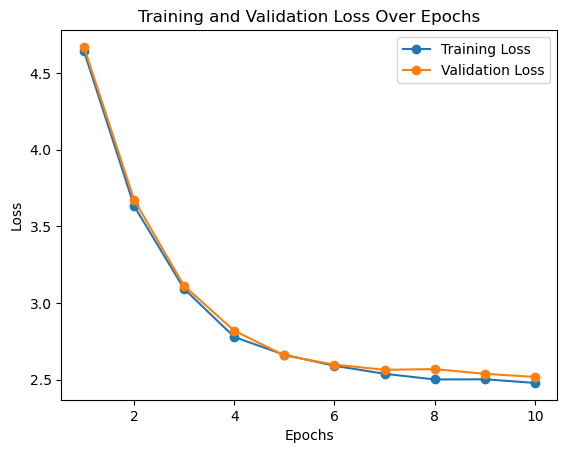

In [239]:
training_params = {
    "model": bigram_model, 
    "train_data": train_set,
    "eval_data": eval_set,
    "epochs": 1000,
    "eval_interval": 100,
    "optimizer": optimizer, 
    "batch_size": 32,
    "context_length": 8, 
    "device": device
}
traning_loss, eval_loss = training_loop(**training_params)

plot_loss(traning_loss, eval_loss)

In [215]:
# Test
test_idx = torch.zeros((1, 1), dtype=torch.long, device='mps')
generated_results = bigram_model.generate(test_idx, max_tokens=300)[0].tolist()
print(decoder(generated_results))


T:
dsceatadsads.
Bolo w ms.
QWI:
Crsp.
I LOMEELI be spruee PUCl ovautone ablak

Iz
O:

houpreyeng faiCAMu h kendany sthongreave spien wour is w-be omou nd whuecithed His nd wnge, co, th.

Moualihimyods nge mybevesit thll:
Fenk'ly litin, It by samel eren tewh llod;3EQBussourpe y t thed cho l restre.

